# Estudio de la evolución de la pandemia por el modelo de red neuronal recurrente para la isla de La Palma

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras import regularizers

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    #plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.show()
    
def visualizar_historico(train, y_test, y_pred, variable, dias_historico, indices, tit, color, dif):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color_isla)
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    plt.bar(indices, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    neurons= X_train.shape[1]
    modelo.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(50, 
                   activation='relu',
                   return_sequences=True))
    modelo.add(Dropout(0.2))
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False))
    modelo.add(Dropout(0.2))
    #modelo.add(Dense(5, activation='relu'))
    modelo.add(Dense(units=1, kernel_regularizer=regularizers.l2(0.01)))
    modelo.compile(optimizer='rmsprop', loss='mean_squared_error')
    historico = modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32, verbose=2)
    
    return modelo, historico
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_resultados_texto(y_test, y_pred, fechas):
    for i in range(len(y_test)):
        print(str(fechas[i]) + ': número de casos reales ' + str(int(y_test[i][0])) + ', número de casos predichos ' + str(y_pred[i][0]))
        
def visualizar_perdida(historico):
    plt.plot(historico.history['loss'], label='train')
    plt.plot(historico.history['val_loss'], label='test')
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.title('Pérdida del modelo')
    plt.legend()
    plt.show() 

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_LaPalma = datos[datos['isla'] == 'LA PALMA']

datos_LaPalma = datos_LaPalma.sort_values(by='fecha') # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_LaPalma = datos_LaPalma.set_index('fecha') # Asignamos la fecha como índice

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a predecir y a agrupar para cada predicción
isla = 'La Palma'         # Isla a la que se está realziando el estudio
fechas = datos_LaPalma.tail(dias_prediccion).index # Fechas de los días a predecir
color_isla = 'darkcyan' # Color de la isla en las visualizaciones
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train

variables_covid = [objetivo, 'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']    # Atributos para el análisis de las variables pandémicas
variables_atm = [objetivo, 'tmin', 'tmed', 'presMax']                            # Atributos para el análisis de las variables atmosféricas
variables = [objetivo,'pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables


In [5]:
# Cargamos los datos de cada estudio con sus atributos correspondientes
datos_LaPalma_uni = datos_LaPalma[objetivo]
datos_LaPalma_uni_arr = np.array(datos_LaPalma_uni).reshape(-1, 1)

datos_LaPalma_mult_covid = datos_LaPalma[variables_covid]
datos_LaPalma_mult_atm = datos_LaPalma[variables_atm]
datos_LaPalma_mult_total = datos_LaPalma[variables]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_uni_scaled = scaler.fit_transform(datos_LaPalma_uni_arr)

In [7]:
n_train = len(datos_LaPalma_uni_scaled) - dias_prediccion


train = datos_LaPalma_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaPalma_uni_scaled[n_train - dias_prediccion:len(datos_LaPalma_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0336 - val_loss: 0.0275 - 3s/epoch - 213ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0308 - val_loss: 0.0270 - 120ms/epoch - 9ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0285 - val_loss: 0.0244 - 120ms/epoch - 9ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0261 - val_loss: 0.0226 - 119ms/epoch - 8ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0238 - val_loss: 0.0200 - 119ms/epoch - 8ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0216 - val_loss: 0.0181 - 120ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0200 - val_loss: 0.0157 - 121ms/epoch - 9ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0178 - val_loss: 0.0145 - 119ms/epoch - 8ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0165 - val_loss: 0.0136 - 121ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0150 - val_loss: 0.0126 - 119ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0138 - val_loss: 0.0128 - 119ms/epoch - 8ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0128 - val_loss: 0.0115 - 119ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s - l

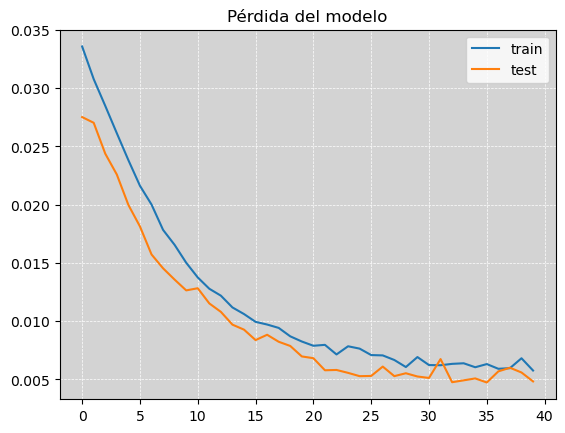

In [10]:
visualizar_perdida(historico)

In [11]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 320ms/step


In [12]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 44, número de casos predichos 76.264275
2022-03-20: número de casos reales 30, número de casos predichos 73.2909
2022-03-21: número de casos reales 127, número de casos predichos 73.1685
2022-03-22: número de casos reales 90, número de casos predichos 71.78597
2022-03-23: número de casos reales 106, número de casos predichos 79.068474
2022-03-24: número de casos reales 70, número de casos predichos 91.41234
2022-03-25: número de casos reales 89, número de casos predichos 86.04077
2022-03-26: número de casos reales 26, número de casos predichos 81.77683
2022-03-27: número de casos reales 15, número de casos predichos 79.47713
2022-03-28: número de casos reales 63, número de casos predichos 74.79533


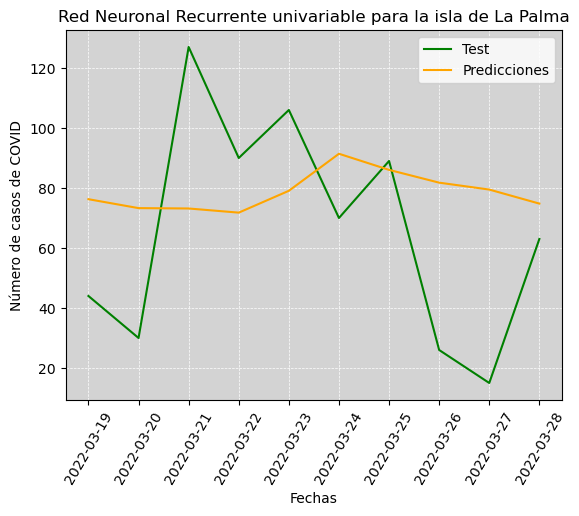

In [13]:
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [14]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-32.2642746 , -43.29090118,  53.83149719,  18.2140274 ,
        26.93152618, -21.41233826,   2.95922852, -55.77683258,
       -64.47712708, -11.79532623])

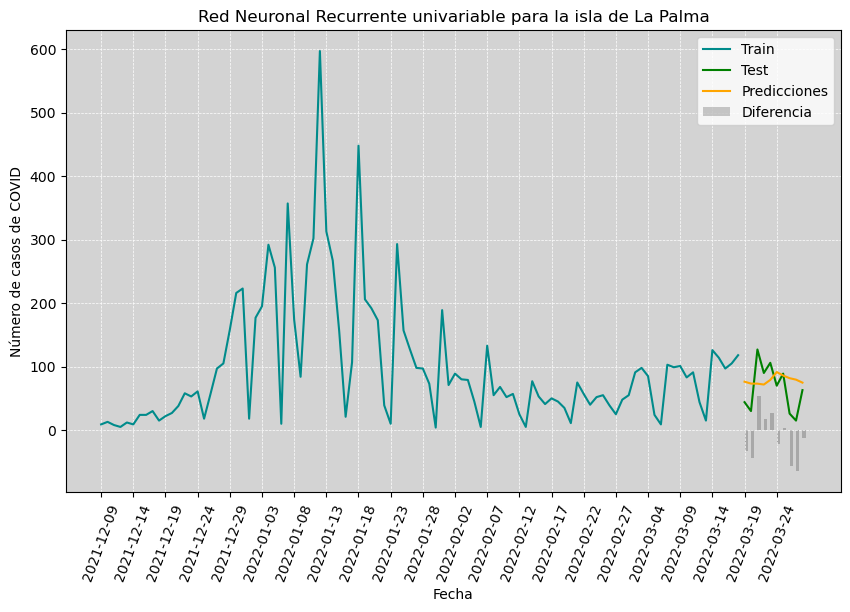

In [15]:
datos_train = datos_LaPalma_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',n_dias_train_vis,fechas,tit,color_isla,dif)

In [16]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1474.4703480056137
Error absoluto medio (MAE) del modelo: 33.09530792236328
Raíz del error cuadrático medio (RMSE) del modelo: 38.39883263857918


# Red Neuronal Recurrente multivariable con variables de pandemia

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_covid_scaled = scaler.fit_transform(datos_LaPalma_mult_covid)


# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaPalma_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_LaPalma_mult_covid_scaled) - dias_prediccion


train = datos_LaPalma_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaPalma_mult_covid_scaled[n_train - dias_prediccion:len(datos_LaPalma_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0298 - val_loss: 0.0223 - 3s/epoch - 216ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0271 - val_loss: 0.0207 - 135ms/epoch - 10ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0237 - val_loss: 0.0241 - 134ms/epoch - 10ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0222 - val_loss: 0.0190 - 131ms/epoch - 9ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0204 - val_loss: 0.0173 - 133ms/epoch - 9ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0185 - val_loss: 0.0200 - 133ms/epoch - 9ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0170 - val_loss: 0.0146 - 136ms/epoch - 10ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0161 - val_loss: 0.0156 - 132ms/epoch - 9ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0152 - val_loss: 0.0147 - 132ms/epoch - 9ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0139 - val_loss: 0.0155 - 133ms/epoch - 9ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0124 - val_loss: 0.0268 - 135ms/epoch - 10ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0123 - val_loss: 0.0105 - 133ms/epoch - 9ms/step
Epoch 13/40
14/14 - 0s

In [21]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-76.19057275, -76.21402334, -76.05154428, -76.11352083,
       -76.08672016, -76.14702167, -76.11519587, -76.22072351,
       -76.23914897, -76.15874696, -73.21719934, -73.24064993,
       -73.07817087, -73.14014742, -73.11334675, -73.17364825,
       -73.14182246, -73.2473501 , -73.26577556, -73.18537355,
       -73.09480097, -73.11825155, -72.95577249, -73.01774904,
       -72.99094837, -73.05124988, -73.01942408, -73.12495172,
       -73.14337718, -73.06297517, -71.71227075, -71.73572134,
       -71.57324228, -71.63521883, -71.60841816, -71.66871966,
       -71.63689387, -71.74242151, -71.76084697, -71.68044496,
       -78.99477197, -79.01822256, -78.8557435 , -78.91772005,
       -78.89091938, -78.95122088, -78.91939509, -79.02492273,
       -79.04334819, -78.96294618, -91.33863641, -91.362087  ,
       -91.19960794, -91.26158449, -91.23478382, -91.29508533,
       -91.26325953, -91.36878717, -91.38721263, -91.30681062,
       -85.96706964, -85.99052023, -85.82804117, -85.89

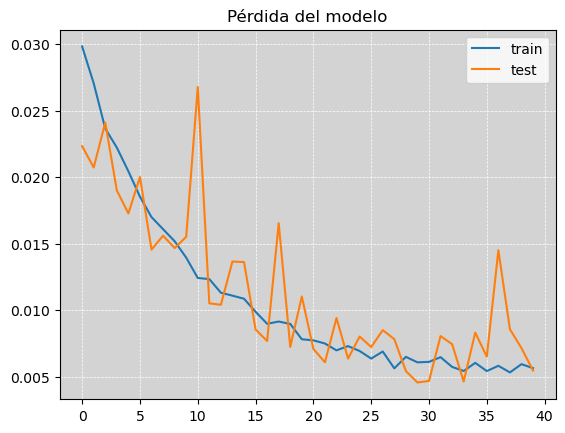

In [22]:
visualizar_perdida(historico)

In [23]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 288ms/step


In [24]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 44, número de casos predichos 81.599266
2022-03-20: número de casos reales 30, número de casos predichos 85.80532
2022-03-21: número de casos reales 127, número de casos predichos 82.05492
2022-03-22: número de casos reales 90, número de casos predichos 81.01348
2022-03-23: número de casos reales 106, número de casos predichos 88.87695
2022-03-24: número de casos reales 70, número de casos predichos 105.14392
2022-03-25: número de casos reales 89, número de casos predichos 97.07678
2022-03-26: número de casos reales 26, número de casos predichos 86.5262
2022-03-27: número de casos reales 15, número de casos predichos 83.50763
2022-03-28: número de casos reales 63, número de casos predichos 81.0784


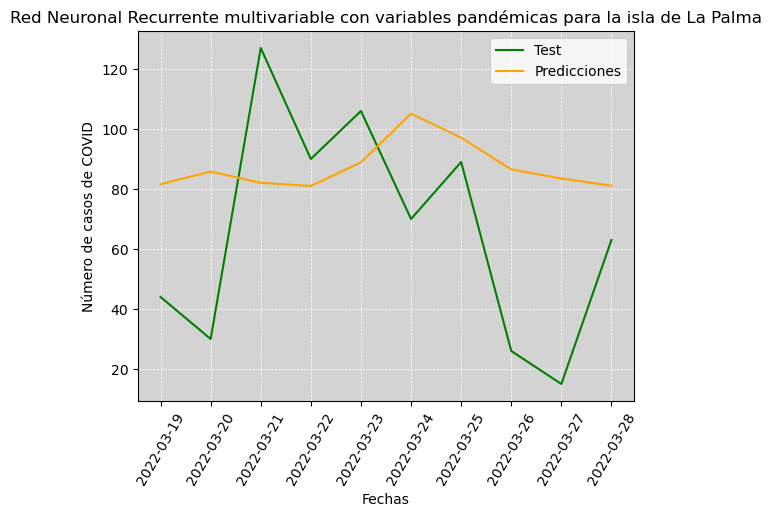

In [25]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [26]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-37.59926605, -55.80532074,  44.94508362,   8.98651886,
        17.12304688, -35.1439209 ,  -8.07678223, -60.52619934,
       -68.50762939, -18.07839966])

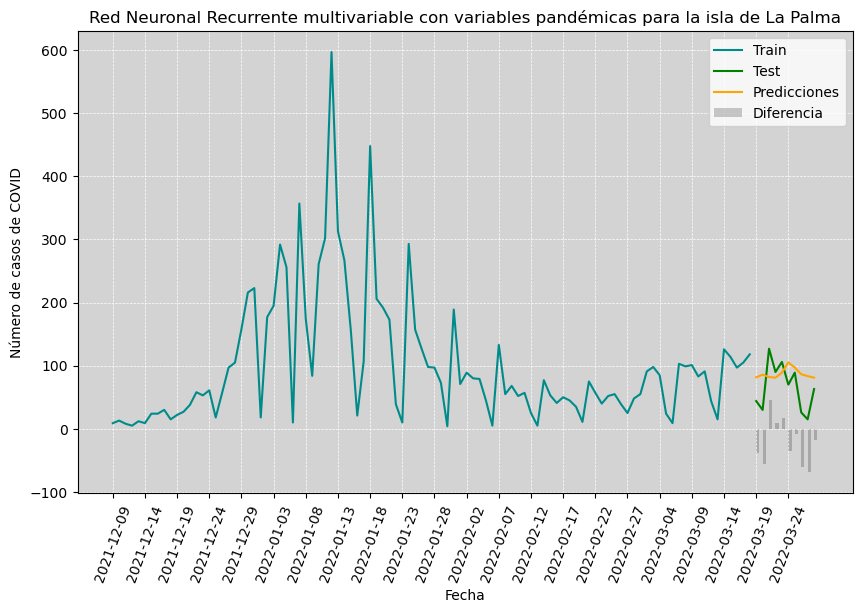

In [27]:
datos_train = datos_LaPalma_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [28]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1690.5829640835232
Error absoluto medio (MAE) del modelo: 35.479216766357425
Raíz del error cuadrático medio (RMSE) del modelo: 41.11669933352534


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_atm_scaled = scaler.fit_transform(datos_LaPalma_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaPalma_mult_atm[objetivo]).reshape(-1, 1))

In [30]:
n_train = len(datos_LaPalma_mult_atm_scaled) - dias_prediccion


train = datos_LaPalma_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaPalma_mult_atm_scaled[n_train - dias_prediccion:len(datos_LaPalma_mult_atm_scaled), :]

In [31]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [32]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0290 - val_loss: 0.0243 - 3s/epoch - 235ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0261 - val_loss: 0.0206 - 141ms/epoch - 10ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0244 - val_loss: 0.0188 - 135ms/epoch - 10ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0223 - val_loss: 0.0165 - 137ms/epoch - 10ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0205 - val_loss: 0.0161 - 137ms/epoch - 10ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0188 - val_loss: 0.0139 - 139ms/epoch - 10ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0175 - val_loss: 0.0132 - 138ms/epoch - 10ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0162 - val_loss: 0.0120 - 207ms/epoch - 15ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0146 - val_loss: 0.0123 - 193ms/epoch - 14ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0137 - val_loss: 0.0140 - 166ms/epoch - 12ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0123 - val_loss: 0.0098 - 177ms/epoch - 13ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0114 - val_loss: 0.0101 - 186ms/epoch - 13ms/step
Epoch 13/40
14/

In [33]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([ -81.52556421,  -81.5490148 ,  -81.38653573,  -81.44851228,
        -81.42171161,  -81.48201312,  -81.45018733,  -81.55571496,
        -81.57414042,  -81.49373841,  -85.7316189 ,  -85.75506948,
        -85.59259042,  -85.65456697,  -85.6277663 ,  -85.68806781,
        -85.65624201,  -85.76176965,  -85.78019511,  -85.6997931 ,
        -81.98121454,  -82.00466513,  -81.84218606,  -81.90416261,
        -81.87736194,  -81.93766345,  -81.90583765,  -82.01136529,
        -82.02979075,  -81.94938874,  -80.9397793 ,  -80.96322988,
        -80.80075082,  -80.86272737,  -80.8359267 ,  -80.89622821,
        -80.86440241,  -80.96993005,  -80.98835551,  -80.9079535 ,
        -88.80325128,  -88.82670187,  -88.66422281,  -88.72619936,
        -88.69939869,  -88.75970019,  -88.7278744 ,  -88.83340204,
        -88.8518275 ,  -88.77142549, -105.07021906, -105.09366964,
       -104.93119058, -104.99316713, -104.96636646, -105.02666797,
       -104.99484217, -105.10036981, -105.11879527, -105.03839

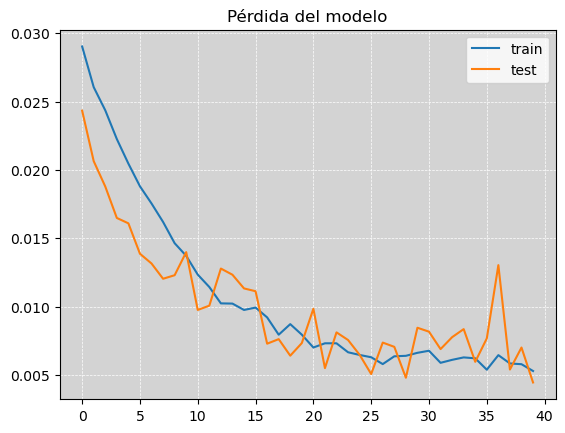

In [34]:
visualizar_perdida(historico)

In [35]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 318ms/step


In [36]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 44, número de casos predichos 72.004875
2022-03-20: número de casos reales 30, número de casos predichos 69.72699
2022-03-21: número de casos reales 127, número de casos predichos 70.10568
2022-03-22: número de casos reales 90, número de casos predichos 69.74679
2022-03-23: número de casos reales 106, número de casos predichos 78.15915
2022-03-24: número de casos reales 70, número de casos predichos 90.960144
2022-03-25: número de casos reales 89, número de casos predichos 84.31746
2022-03-26: número de casos reales 26, número de casos predichos 79.27775
2022-03-27: número de casos reales 15, número de casos predichos 77.1724
2022-03-28: número de casos reales 63, número de casos predichos 72.29392


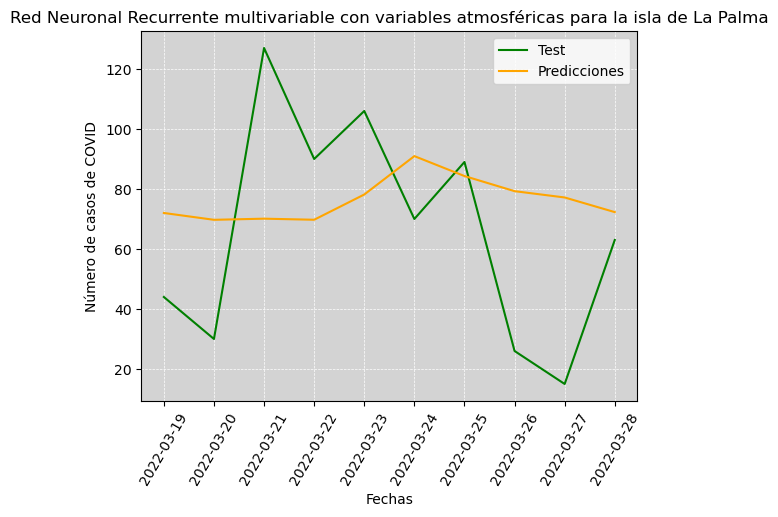

In [37]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [38]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([-28.00487518, -39.72698975,  56.89431763,  20.25321198,
        27.84085083, -20.96014404,   4.68254089, -53.27774811,
       -62.17240143,  -9.29392242])

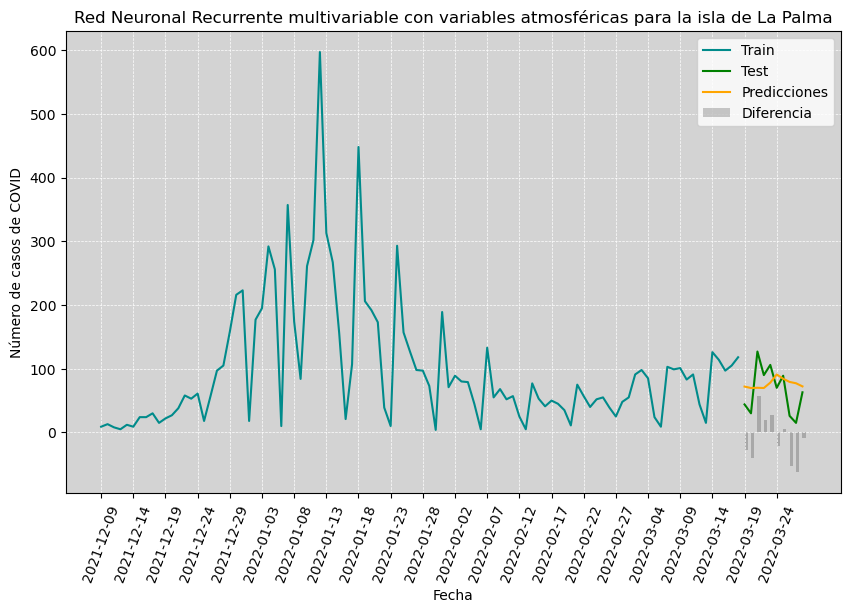

In [39]:
datos_train = datos_LaPalma_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [40]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1403.6332461148093
Error absoluto medio (MAE) del modelo: 32.310700225830075
Raíz del error cuadrático medio (RMSE) del modelo: 37.465093702202445


# Red Neuronal Recurrente multivariable con todas las variables

In [41]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_total_scaled = scaler.fit_transform(datos_LaPalma_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_LaPalma_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_LaPalma_mult_total[objetivo]).reshape(-1, 1))

In [42]:
n_train = len(datos_LaPalma_mult_total_scaled) - dias_prediccion


train = datos_LaPalma_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_LaPalma_mult_total_scaled[n_train - dias_prediccion:len(datos_LaPalma_mult_total_scaled), :]

In [43]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [44]:
modelo, historico = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/40
14/14 - 3s - loss: 0.0273 - val_loss: 0.0204 - 3s/epoch - 226ms/step
Epoch 2/40
14/14 - 0s - loss: 0.0246 - val_loss: 0.0176 - 149ms/epoch - 11ms/step
Epoch 3/40
14/14 - 0s - loss: 0.0220 - val_loss: 0.0169 - 158ms/epoch - 11ms/step
Epoch 4/40
14/14 - 0s - loss: 0.0200 - val_loss: 0.0151 - 147ms/epoch - 10ms/step
Epoch 5/40
14/14 - 0s - loss: 0.0189 - val_loss: 0.0143 - 148ms/epoch - 11ms/step
Epoch 6/40
14/14 - 0s - loss: 0.0170 - val_loss: 0.0142 - 151ms/epoch - 11ms/step
Epoch 7/40
14/14 - 0s - loss: 0.0159 - val_loss: 0.0159 - 153ms/epoch - 11ms/step
Epoch 8/40
14/14 - 0s - loss: 0.0149 - val_loss: 0.0214 - 150ms/epoch - 11ms/step
Epoch 9/40
14/14 - 0s - loss: 0.0137 - val_loss: 0.0187 - 150ms/epoch - 11ms/step
Epoch 10/40
14/14 - 0s - loss: 0.0125 - val_loss: 0.0210 - 151ms/epoch - 11ms/step
Epoch 11/40
14/14 - 0s - loss: 0.0114 - val_loss: 0.0206 - 153ms/epoch - 11ms/step
Epoch 12/40
14/14 - 0s - loss: 0.0120 - val_loss: 0.0134 - 148ms/epoch - 11ms/step
Epoch 13/40
14/

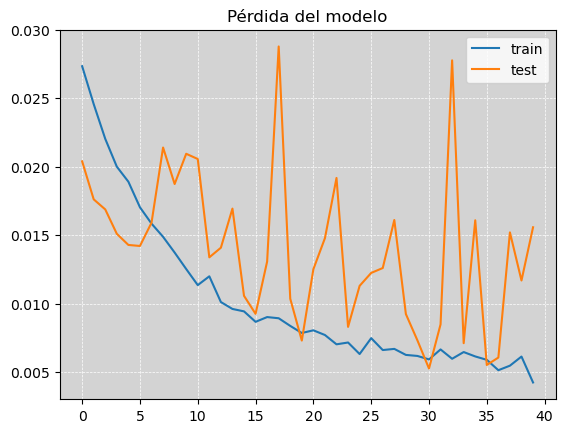

In [45]:
visualizar_perdida(historico)

In [46]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 302ms/step


In [47]:
visualizar_resultados_texto(y_test, y_pred, fechas)

2022-03-19: número de casos reales 44, número de casos predichos 123.216484
2022-03-20: número de casos reales 30, número de casos predichos 129.17258
2022-03-21: número de casos reales 127, número de casos predichos 122.907814
2022-03-22: número de casos reales 90, número de casos predichos 119.08728
2022-03-23: número de casos reales 106, número de casos predichos 130.34483
2022-03-24: número de casos reales 70, número de casos predichos 151.33162
2022-03-25: número de casos reales 89, número de casos predichos 144.14223
2022-03-26: número de casos reales 26, número de casos predichos 129.95183
2022-03-27: número de casos reales 15, número de casos predichos 124.59654
2022-03-28: número de casos reales 63, número de casos predichos 118.245384


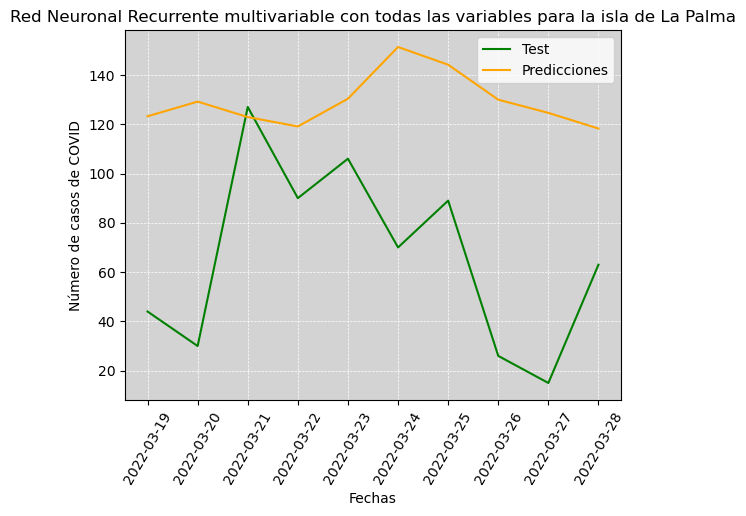

In [48]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

In [49]:
dif = y_test - y_pred
dif = dif.flatten()
dif

array([ -79.21648407,  -99.1725769 ,    4.09218597,  -29.08728027,
        -24.34483337,  -81.33161926,  -55.14222717, -103.951828  ,
       -109.59654236,  -55.24538422])

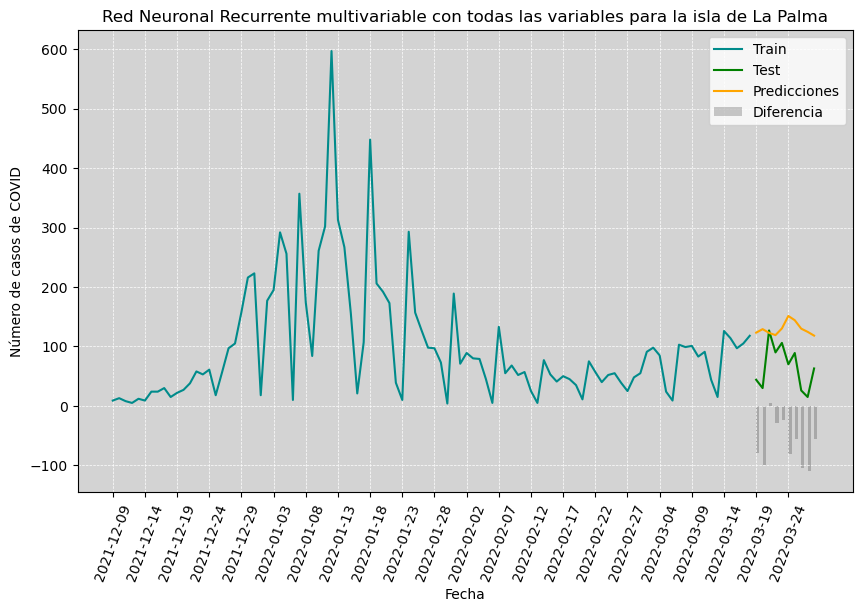

In [50]:
datos_train = datos_LaPalma_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,n_dias_train_vis,fechas,tit,color_isla,dif)

In [51]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 5309.087275873351
Error absoluto medio (MAE) del modelo: 64.11809616088867
Raíz del error cuadrático medio (RMSE) del modelo: 72.8634838301968
